# 변수중요도 : Feature Importance



## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

### 2) 데이터 로딩

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 생성

In [4]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비


### 1) x, y로 나누기 

In [5]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

### 3) train : validation 분할

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)
x_train.shape

(404, 13)

## 3.Feature Importance

### 1) Decision Tree

In [8]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import * 

* 기본 모델

In [9]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

* 모델 시각화

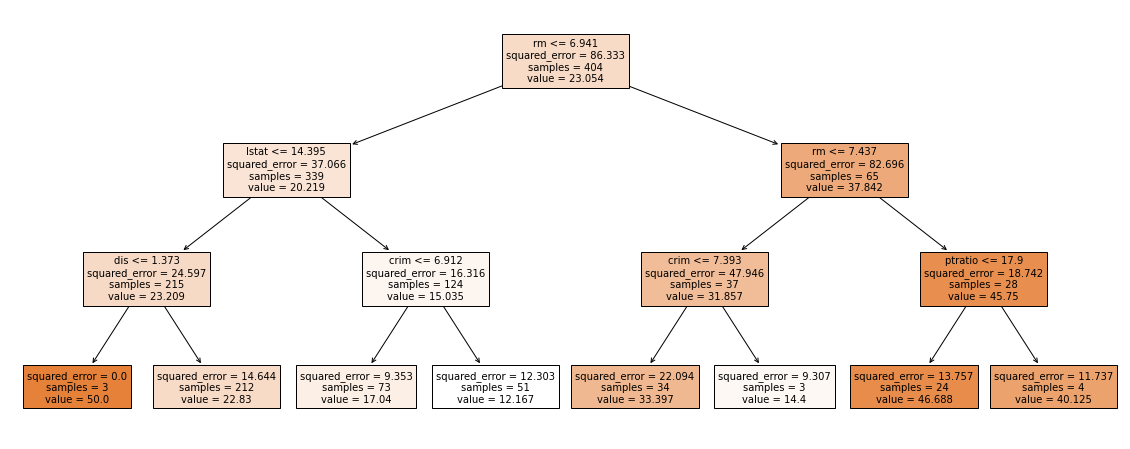

In [10]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10);

* 변수 중요도

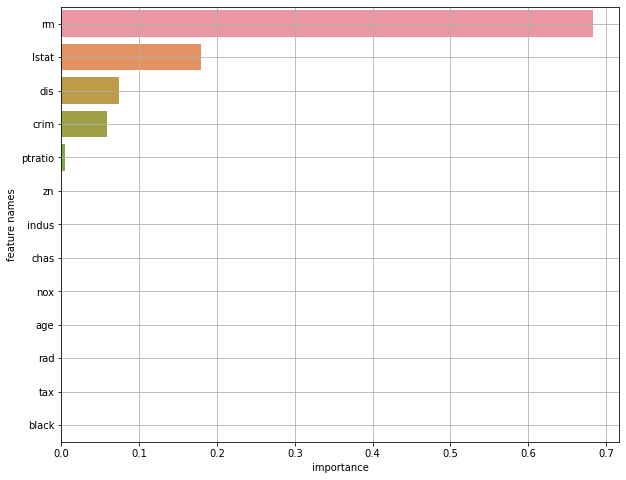

In [13]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [14]:
result

,feature_names,feature_importance
0,rm,0.682914
1,lstat,0.179261
2,dis,0.074513
3,crim,0.058274
4,ptratio,0.005038
5,zn,0.000000
6,indus,0.000000
7,chas,0.000000
8,nox,0.000000
9,age,0.000000


* 성능 최적화 이후 변수 중요도 다시 확인

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

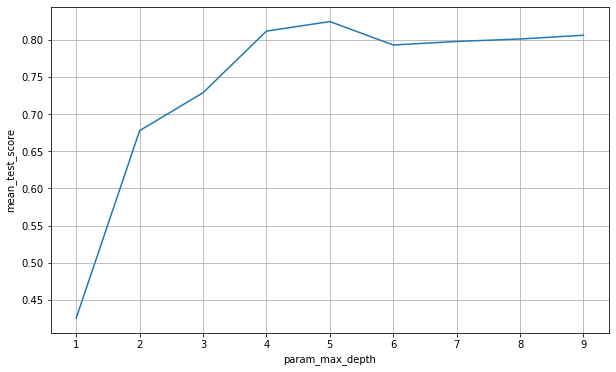

In [16]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [19]:
best_model = model_gs.best_estimator_

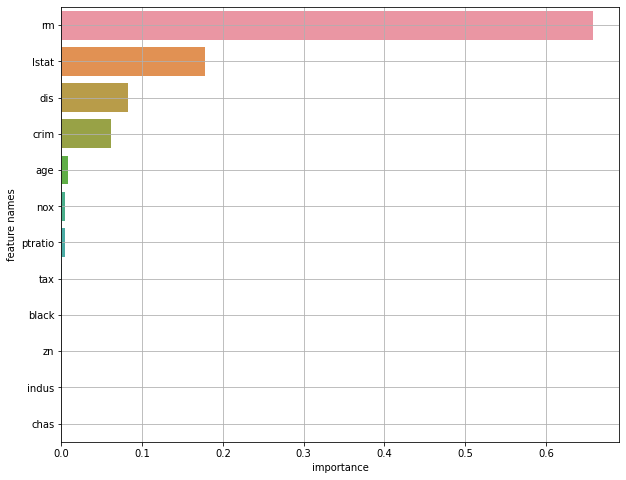

In [20]:
result = plot_feature_importance(best_model.feature_importances_, list(x),12)

In [21]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

3.1109920566467055


### 2) Random Forest

* 기본모델링

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

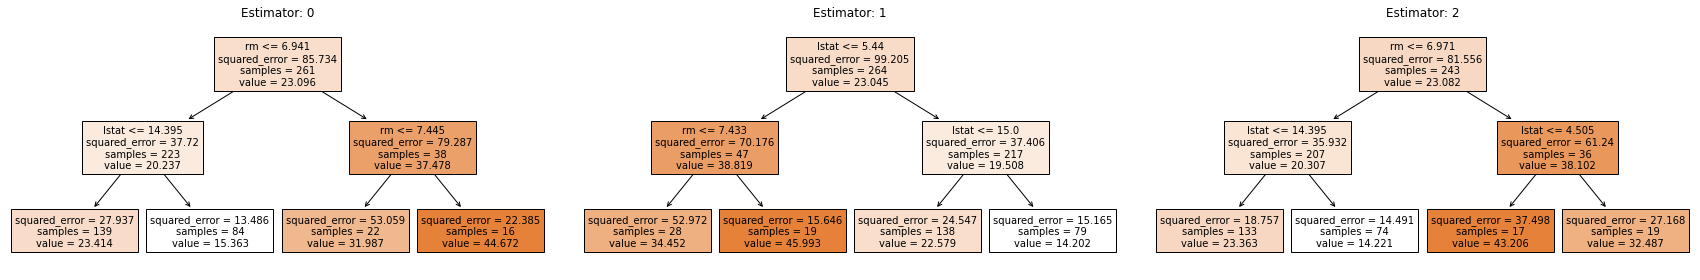

In [24]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)
    
plt.tight_layout()
plt.show()

In [26]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [27]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.786804,0.0,0.0,0.0,0.0,0.0,0.0,0.213196
1,0.0,0.0,0.0,0.0,0.0,0.076663,0.0,0.0,0.0,0.0,0.0,0.0,0.923337
2,0.0,0.0,0.0,0.0,0.0,0.673878,0.0,0.0,0.0,0.0,0.0,0.0,0.326122


In [30]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.512448
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
black      0.000000
lstat      0.487552
dtype: float64

In [29]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.0,0.0,0.0,0.0,0.0,0.512448,0.0,0.0,0.0,0.0,0.0,0.0,0.487552


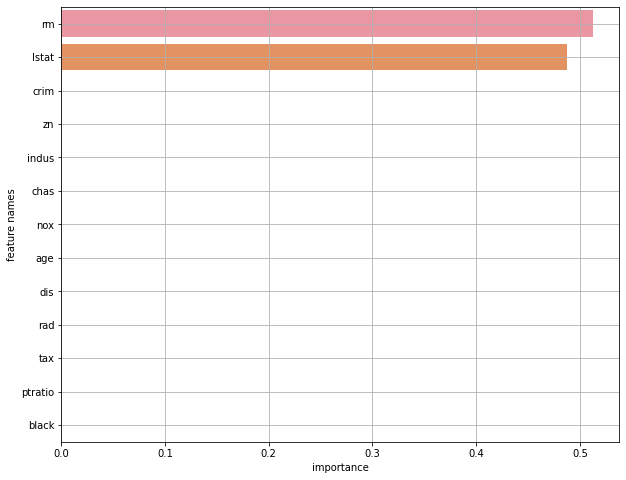

In [31]:
result = plot_feature_importance(model.feature_importances_, list(x))

* tree = 100개 Random Forest 모델 만들기

In [32]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

* 트리 전체 중요도 저장

In [33]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [34]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.035161,0.001063,0.003928,0.000527,0.017918,0.666936,0.007251,0.086251,0.002106,0.011244,0.001714,0.004222,0.161679
1,0.033329,0.001485,0.001266,0.000689,0.016049,0.610499,0.009115,0.056967,0.003561,0.025237,0.003169,0.016683,0.221951
2,0.014591,0.002629,0.000670,0.000068,0.086651,0.618093,0.010449,0.038841,0.003539,0.024726,0.003332,0.005192,0.191219
3,0.041089,0.000293,0.010015,0.001733,0.007831,0.588370,0.032704,0.095989,0.001513,0.003584,0.012352,0.013151,0.191375
4,0.010629,0.009188,0.002302,0.000633,0.023939,0.640799,0.018618,0.097785,0.000019,0.004182,0.006364,0.006877,0.178664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.038936,0.000474,0.009510,0.017180,0.006890,0.661264,0.007317,0.008951,0.003172,0.003645,0.012320,0.012857,0.217486
96,0.022896,0.001996,0.005632,0.000000,0.012716,0.177101,0.018305,0.034136,0.006422,0.027346,0.018914,0.009093,0.665443
97,0.033321,0.000496,0.004149,0.000000,0.011126,0.683771,0.010325,0.026769,0.000670,0.003971,0.005312,0.004665,0.215423
98,0.023252,0.000637,0.008371,0.000182,0.001137,0.248939,0.031443,0.070002,0.000836,0.006432,0.003485,0.005733,0.599551


* 트리 100개의 평균 중요도

In [35]:
fi.mean(axis = 0)

crim       0.036301
zn         0.000907
indus      0.006019
chas       0.001688
nox        0.014886
rm         0.508038
age        0.013402
dis        0.065689
rad        0.002706
tax        0.010499
ptratio    0.010628
black      0.008854
lstat      0.320383
dtype: float64

In [36]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.036301,0.000907,0.006019,0.001688,0.014886,0.508038,0.013402,0.065689,0.002706,0.010499,0.010628,0.008854,0.320383


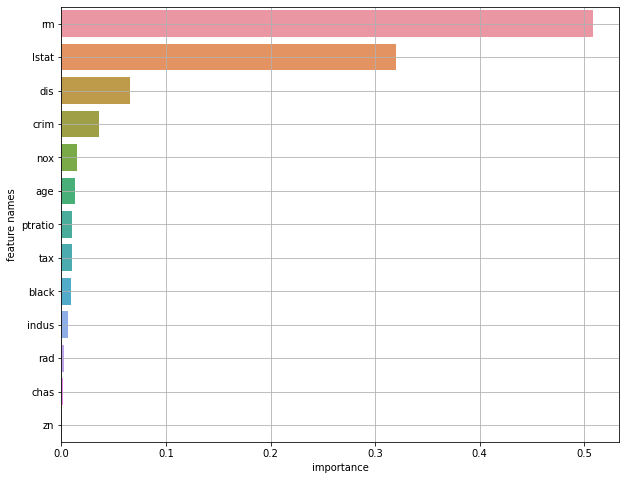

In [37]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [38]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.5065


### 3) XGB

In [40]:
from xgboost import XGBRegressor, plot_tree, plot_importance

* 기본 모델링

In [41]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(max_depth=2, n_estimators=10, objective='reg:squarederror')

* plot tree
    * plot tree함수는 XGB에서 제공합니다.
    * XGB에서의 트리 시각화는 여러 estimator중 하나씩만 가능합니다.

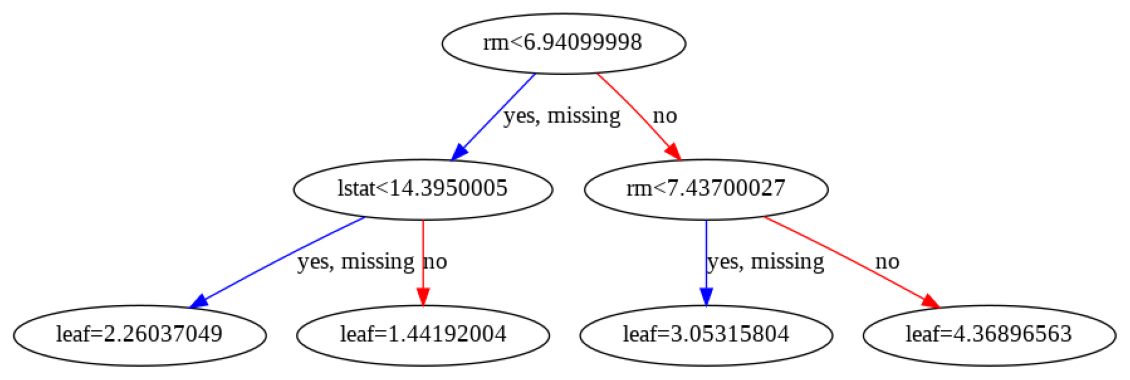

In [42]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.

* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

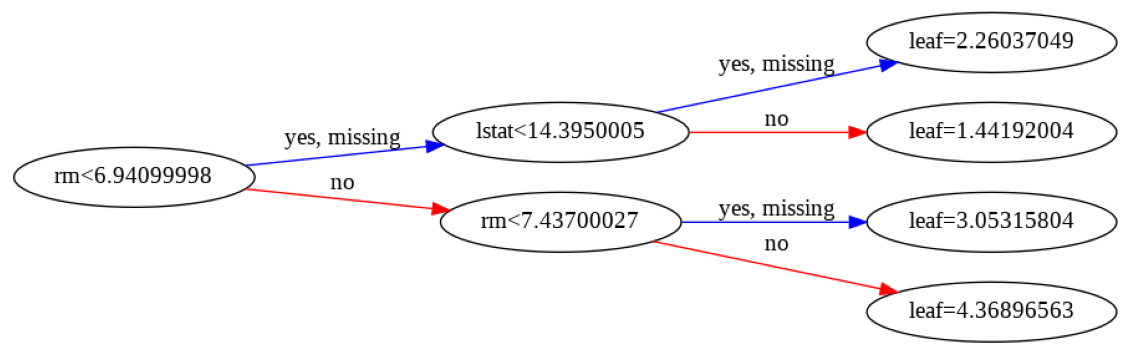

In [43]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

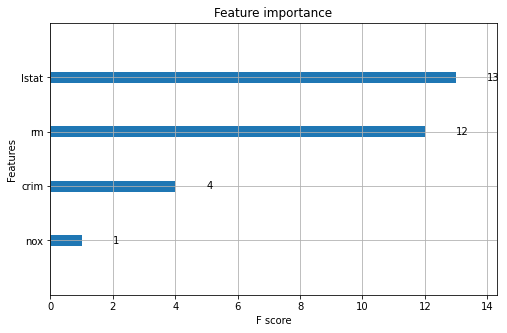

In [44]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

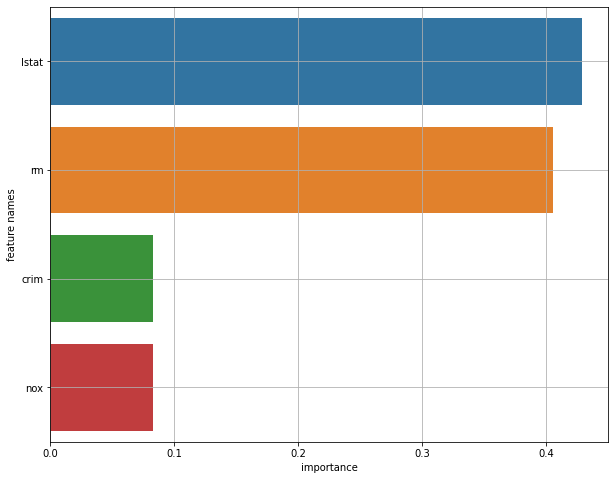

In [45]:
result = plot_feature_importance(model.feature_importances_, list(x),4)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

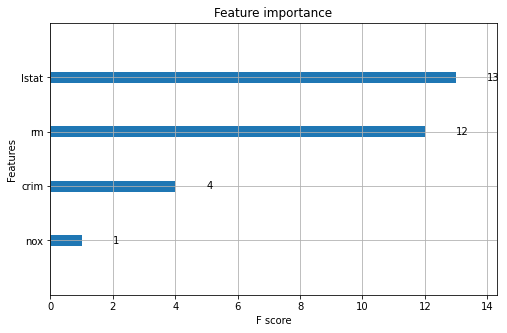

In [46]:
# importance_type='weight'
plot_importance(model)
plt.show()

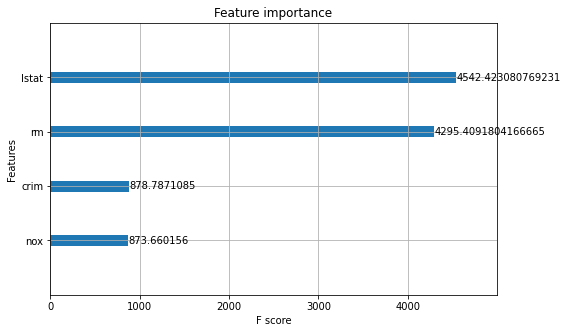

In [50]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

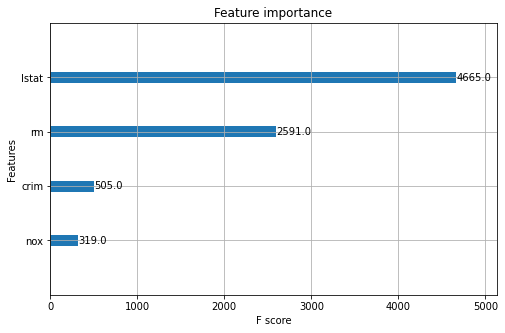

In [52]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()

## 4.실습 : 직원 이직 예측모델 변수 중요도 비교

### 4.1 데이터 준비

* 데이터 로딩

In [53]:
# data data
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/Attrition2.csv"
data = pd.read_csv(path)
data.head(10)

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1
5,0,44,Research & Development,2,1,Medical,Male,Manufacturing Director,3,Single,10209,5,2,16,2,2,2
6,0,41,Sales,10,2,Life Sciences,Male,Sales Executive,4,Single,6230,7,4,16,3,3,14
7,0,25,Sales,18,1,Life Sciences,Male,Sales Executive,3,Married,6232,2,2,6,3,2,3
8,0,50,Research & Development,2,3,Medical,Male,Research Director,3,Married,17639,5,4,30,3,3,4
9,0,47,Sales,4,2,Life Sciences,Female,Sales Executive,4,Single,4163,1,3,9,0,3,9


|	변수 명	|	내용	|	구분	|
|	----	|	----	|	----	|
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|
|	Age	|	나이	|	숫자	|
|	BusinessTravel	|	출장 빈도(범주)	|		|
|	Department	|	현 부서	|		|
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|
|	EducationField	|	전공	|		|
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|
|	Gender	|	성별	|		|
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	JobRole	|	직무	|		|
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	MaritalStatus	|	결혼상태	|		|
|	MonthlyIncome	|	월급	|	숫자	|
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|


In [54]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [55]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

* 가변수화 Dummy Variable

In [56]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] 
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True) 

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [59]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


* class balance를 맞추기 위한 resampling

In [60]:
from imblearn.over_sampling import SMOTE

In [79]:
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(y_train))
print(np.bincount(y_train) / y_train.shape[0])

[833 833]
[0.5 0.5]


### 4.2 모델링 with Resampling
> * Resampling(up) 샘플링 데이터를 이용
* DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성
* validate set으로 예측하고 평가(classification report)해 봅시다.
* 각각의 변수중요도 비교하기.



* 모델링
    * DecisionTreeClassifier, RandomForestClassifier, XGBClassifier를 이용하여 모델 생성

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

* decision tree

In [98]:
# depth의 범위 1~10까지 안에서 그리드서치로 튜닝해 봅시다.

params = {'max_depth':range(1, 30)}

model1 = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
model1.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 30)})

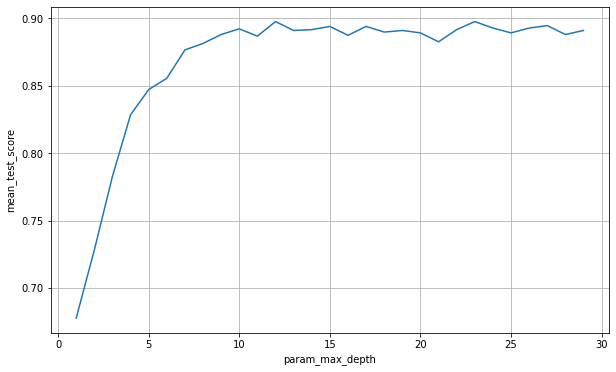

In [99]:
# 튜닝 과정 로그를 df로 저장 합시다.
result = pd.DataFrame(model1.cv_results_)

# 튜닝 결과를 그래프로 그려봅시다.
plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

* rf

In [100]:
# 기본값으로 모델을 생성합니다.
model2 = RandomForestClassifier()
model2.fit(x_train, y_train)

RandomForestClassifier()

* xgb

In [101]:
# 다음 범위로 그리드서치 튜닝을 진행합시다.
# max_depth : 1 ~ 6, learning_rate : 0.01 ~ 0.4, n_estimators : 50 ~ 150

params = {'max_depth':[3], 'learning_rate':np.linspace(0.01,0.4, 10)
            , 'n_estimators':range(50,201,10)}
model3 = GridSearchCV(XGBClassifier(), params, cv = 5)
model3.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                         'max_depth': [3], 'n_estimators': range(50, 201, 10)})

In [102]:
model3.best_params_

{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 140}

* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

In [104]:
pred1 = model1.predict(x_val)
pred2 = model2.predict(x_val)
pred3 = model3.predict(x_val)

In [106]:
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1 ))

[[188  29]
 [  7   6]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       217
           1       0.17      0.46      0.25        13

    accuracy                           0.84       230
   macro avg       0.57      0.66      0.58       230
weighted avg       0.92      0.84      0.88       230



In [71]:
print(confusion_matrix(y_val, pred2 ))
print(classification_report(y_val, pred2 ))

[[213   4]
 [  9   4]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       217
           1       0.50      0.31      0.38        13

    accuracy                           0.94       230
   macro avg       0.73      0.64      0.68       230
weighted avg       0.93      0.94      0.94       230



In [72]:
print(confusion_matrix(y_val, pred3 ))
print(classification_report(y_val, pred3 ))

[[205  12]
 [ 12   1]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       217
           1       0.08      0.08      0.08        13

    accuracy                           0.90       230
   macro avg       0.51      0.51      0.51       230
weighted avg       0.90      0.90      0.90       230



* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다. 

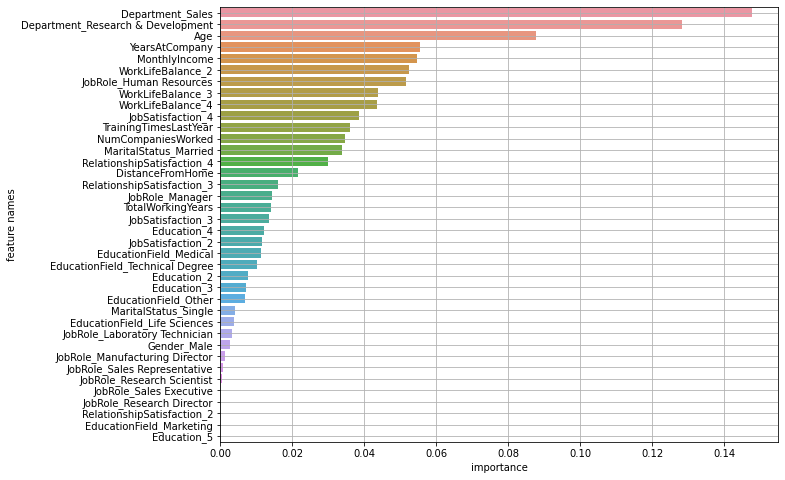

In [73]:
result1 = plot_feature_importance(model1.best_estimator_.feature_importances_, list(x))

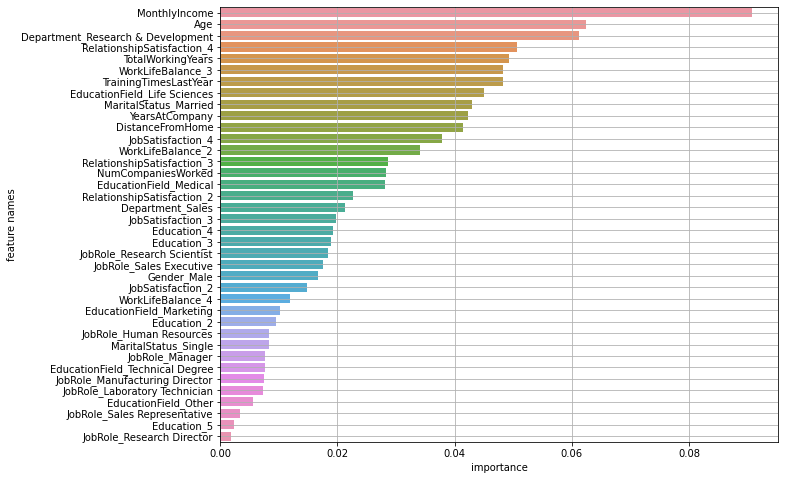

In [74]:
result2 = plot_feature_importance(model2.feature_importances_, list(x))

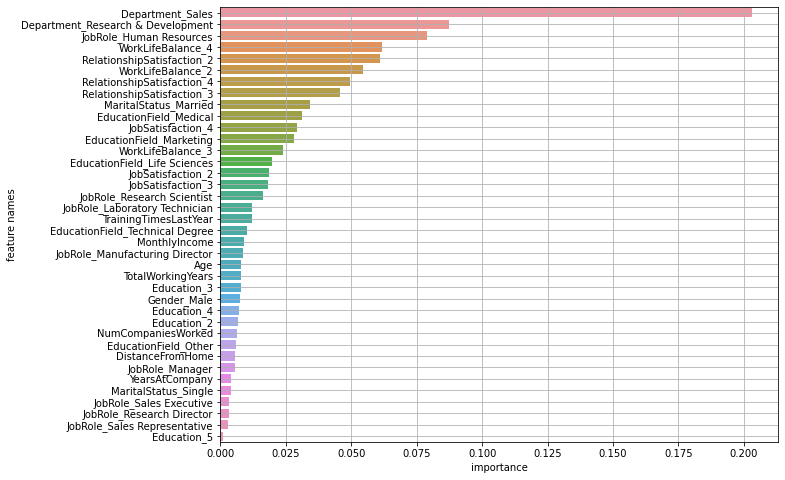

In [75]:
result3 = plot_feature_importance(model3.best_estimator_.feature_importances_, list(x))

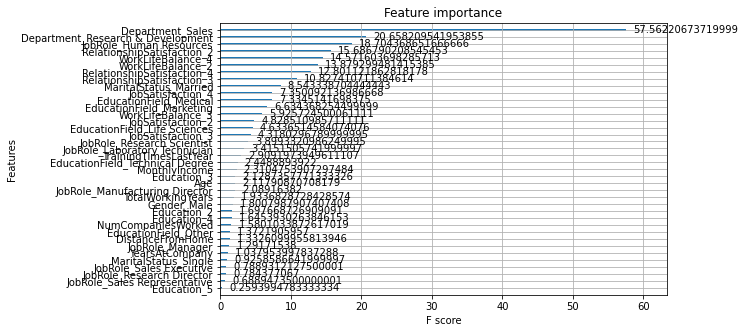

In [87]:
plot_importance(model3.best_estimator_, importance_type='gain')
plt.show()

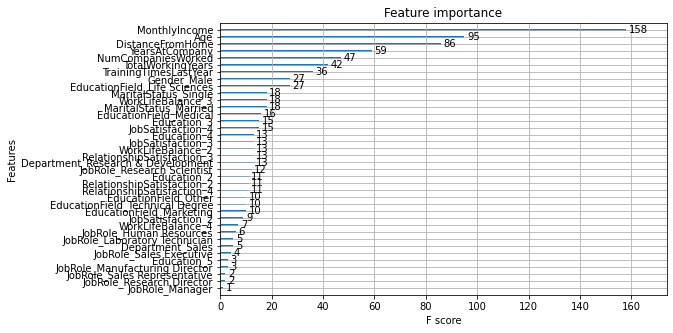

In [107]:
# weight
plot_importance(model3.best_estimator_)
plt.show()

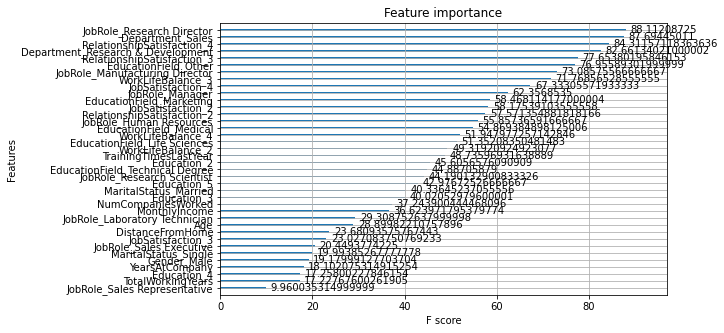

In [89]:
# cover
plot_importance(model3.best_estimator_, importance_type='cover')
plt.show()

* 변수 중요도의 차이를 통해 무엇을 파악할 수 있나요?

______
